

---




---



# **Comparison of Linear Regression Implementations: Pure Python, NumPy, and Scikit-learn**


---



---





> Below is the setup, firstly this code was meant to work on google colab, so the G drive is mounted with the location of the stored dataset.
And other used libraries were improted.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

import time
import csv
import copy, math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




> **Loading Dataset** : Load CSV Data as NumPy arrays
path is the location were the dataset is stored. Here, the dataset is stored in my Google drive.



In [3]:
path = '/content/drive/MyDrive/housing.csv'

def load_data(path):
    X, y = [], []
    with open(path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                X.append([
                    float(row['longitude']),
                    float(row['latitude']),
                    float(row['housing_median_age']),
                    float(row['total_rooms']),
                    float(row['total_bedrooms']),
                    float(row['population']),
                    float(row['households']),
                    float(row['median_income'])
                ])
                y.append(float(row['median_house_value']))
            except ValueError:
                continue
    return np.array(X), np.array(y)

X, y = load_data(path)


In [4]:
print ('The shape of X is:', X.shape)
print('The shape of y is: ', y.shape)
print('Number of training examples (m):', len(X))

The shape of X is: (20433, 8)
The shape of y is:  (20433,)
Number of training examples (m): 20433




> **Normalizing features and Targets** :  Features were normalized using the Z-score normalization(commonly used as it prevents the cost function to be elongated, rather it makes a nearly
uniform cost function which helps to run the gradient descent much faster) to zero mean and
standard variance to ensure fair convergence during gradient descent



In [5]:
def normalize_features(X):
    X = np.array(X)
    means = X.mean(axis=0)
    stds = X.std(axis=0) + 1e-8    #adding small constant to avoid any division by zero.
    X_norm = (X - means) / stds
    return X_norm, means, stds

X_norm, means, stds = normalize_features(X)

mean_y = np.mean(y)
std_y = np.std(y) + 1e-8
y_norm = (y - mean_y) / std_y
print('The shape of y_norm is: ', y_norm.shape)

The shape of y_norm is:  (20433,)




> **Split into Training and Cross Validation Sets** :  The dataset was split
into 70% training and 30% cross-validation sets for giving the model appropriate number
of examples to cross validate with new data. Also used ”random state” in the train test split() function to divide the same examples in train and CV
set, because train test split() function randomly divides the dataset, which is not feasible
for fair comparison.



In [6]:
# === Split into Training and Cross Validation Sets ===
X_train, X_cv, y_train, y_cv = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)    #split the dataset into 70% train and 30% cross validation set
print("Training set size (X_train):", X_train.shape)
print("Cross-validation set size (X_cv):", X_cv.shape)


Training set size (X_train): (14303, 8)
Cross-validation set size (X_cv): (6130, 8)




---



 > # Pure Python Implementation



In [7]:
#part 1
#-------PURE PYTHON IMPLEMENTATION---------------

def predict(X, W, b):
    predictions = []
    for i in range(len(X)):
        y_hat = 0.0
        for j in range(len(W)):
            y_hat += X[i][j] * W[j]
        y_hat += b
        predictions.append(y_hat)
    return predictions


def compute_cost(X, y, W, b):
    m = len(y)
    y_hat = predict(X, W, b)
    squared_errors = []
    for i in range(m):
        error = y_hat[i] - y[i]
        squared_errors.append(error ** 2)
    cost = sum(squared_errors) / (2 * m)
    return cost


def compute_gradient(X, y, W, b):
    m = len(y)    # no. of training examples
    n = len(W)  # no. of features
    y_hat = predict(X, W, b)

    dW = np.zeros(n)
    db = 0.0

    for i in range(m):
        error = y_hat[i] - y[i]
        for j in range(n):
            dW[j] += error * X[i][j]
        db += error

    for j in range(n):
        dW[j] = dW[j] / m
    db = db / m

    return dW, db


def gradient_descent(X, y, W, b, learning_rate, num_iters):
    cost_history = []

    start_time = time.time()  # measure start
    for iter in range(num_iters):
        dW, db = compute_gradient(X, y, W, b)

        for j in range(len(W)):
            W[j] -= learning_rate * dW[j]
        b -= learning_rate * db

        cost = compute_cost(X, y, W, b)
        cost_history.append(cost)

        if iter % 100 == 0 or iter == num_iters - 1:        #for printing cost after every 100 iterations
            print(f"Iteration {iter}: Cost = {cost}")
    end_time = time.time()  # measure end
    print(f"Pure Python Time Taken: {end_time - start_time:.6f} seconds\n")

    return W, b, cost_history

In [8]:
# train pure Python on training set
initial_W_py = np.zeros(X_train.shape[1])
initial_b_py = 0.0
W_py, b_py, cost_history_py = gradient_descent(X_train.tolist(), y_train.tolist(), initial_W_py.copy(), initial_b_py, learning_rate=0.01, num_iters=1000)

Iteration 0: Cost = 0.49456713967890215
Iteration 100: Cost = 0.26600408763652267
Iteration 200: Cost = 0.22753158882658697
Iteration 300: Cost = 0.21676701386408145
Iteration 400: Cost = 0.21102996959105766
Iteration 500: Cost = 0.20675945102751417
Iteration 600: Cost = 0.20326813621016254
Iteration 700: Cost = 0.20034771246778263
Iteration 800: Cost = 0.19788776953603723
Iteration 900: Cost = 0.1958086970136762
Iteration 999: Cost = 0.19406344207646242
Pure Python Time Taken: 175.871535 seconds





---





> # NumPy Implementation





In [9]:
#part 2
#---------NUMPY IMPLEMENTATION-------------

def predict_np(X, W, b):
    return np.dot(X, W) + b


def compute_cost_np(X, y, W, b):
    m = len(y)  # no. of training examples
    y_hat = predict_np(X, W, b)
    cost = np.sum((y_hat - y) ** 2) / (2 * m)
    return cost


def compute_gradient_np(X, y, W, b):
    m = len(y)
    y_hat = predict_np(X, W, b)
    error = y_hat - y

    dW = np.dot(X.T, error) / m
    db = np.sum(error) / m

    return dW, db


def gradient_descent_np(X, y, W, b, learning_rate, num_iters):
    cost_history = []

    start_time = time.time()  # measure start
    for iter in range(num_iters):
        dW, db = compute_gradient_np(X, y, W, b)

        W -= learning_rate * dW
        b -= learning_rate * db

        cost = compute_cost_np(X, y, W, b)
        cost_history.append(cost)

        if iter % 100 == 0 or iter == num_iters - 1:
            print(f"Iteration {iter}: Cost = {cost}")
    end_time = time.time()  #measure end
    print(f"NumPy Time Taken: {end_time - start_time:.6f} seconds\n")

    return W, b, cost_history



In [10]:
# train NumPy on training set
initial_W_np = np.zeros(X_train.shape[1])
initial_b_np = 0.0
W_np, b_np, cost_history_np = gradient_descent_np(X_train, y_train, initial_W_np.copy(), initial_b_np, learning_rate=0.01, num_iters=1000)

Iteration 0: Cost = 0.49456713967890276
Iteration 100: Cost = 0.2660040876365226
Iteration 200: Cost = 0.22753158882658747
Iteration 300: Cost = 0.2167670138640816
Iteration 400: Cost = 0.21102996959105907
Iteration 500: Cost = 0.20675945102751486
Iteration 600: Cost = 0.20326813621016268
Iteration 700: Cost = 0.20034771246778402
Iteration 800: Cost = 0.19788776953603748
Iteration 900: Cost = 0.19580869701367618
Iteration 999: Cost = 0.19406344207646203
NumPy Time Taken: 0.279125 seconds





---



> #  Scikit Learn Implementation



In [11]:
#part 3
#-------------SCIKIT LEARN IMPLEMENTATION-------

model = LinearRegression()

start_time = time.time()    #measure start
model.fit(X_train, y_train)
end_time = time.time()  # measure end

y_train_pred_sk = model.predict(X_train)
y_cv_pred_sk = model.predict(X_cv)

mse_train_sk = mean_squared_error(y_train, y_train_pred_sk)
mse_cv_sk = mean_squared_error(y_cv, y_cv_pred_sk)
cost_train_sk = mse_train_sk/2
cost_cv_sk = mse_cv_sk/2

print(f"Training Cost (MSE/2): {cost_train_sk}")
print(f"Validation Cost (MSE/2): {cost_cv_sk}")

#Model parameters
W = model.coef_    # weights vector
b = model.intercept_  # bias term

print("Weights (W):", W)
print("Bias (b):", b)
print(f"Scikit-learn Time Taken: {end_time - start_time:.6f} seconds\n")

Training Cost (MSE/2): 0.18324915763632302
Validation Cost (MSE/2): 0.17782607407303816
Weights (W): [-0.73117077 -0.77844103  0.12957153 -0.16240094  0.43119642 -0.34923427
  0.12375407  0.66355483]
Bias (b): 0.0013913221605172817
Scikit-learn Time Taken: 0.063424 seconds





---



> # Visualization



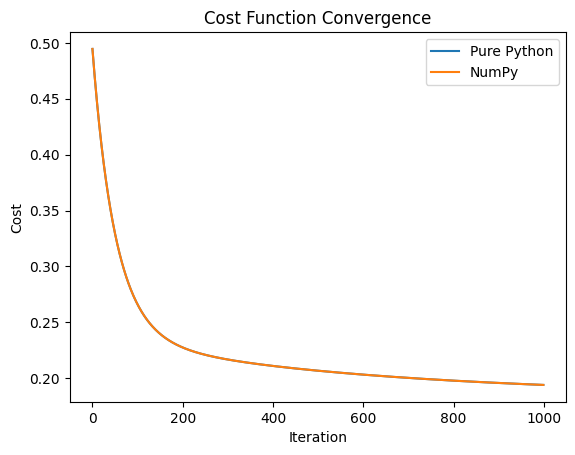

In [12]:
# Cost Function Convergence Plot
plt.figure()
plt.plot(cost_history_py, label='Pure Python')
plt.plot(cost_history_np, label='NumPy')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.legend()
plt.show()






> # Performance Metrics





In [15]:
# ------------------- Performance Metrics -------------------
# Pure Python metrics
y_train_pred_py = predict(X_train.tolist(), W_py, b_py)
y_cv_pred_py    = predict(X_cv.tolist(),    W_py, b_py)
print("-- Pure Python --")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_py))
print("Train RMSE:", math.sqrt(mean_squared_error(y_train, y_train_pred_py)))
print("Train R2: ", r2_score(y_train, y_train_pred_py))
print("CV MAE:", mean_absolute_error(y_cv, y_cv_pred_py))
print("CV RMSE:", math.sqrt(mean_squared_error(y_cv, y_cv_pred_py)))
print("CV R2: ", r2_score(y_cv, y_cv_pred_py), "\n")

# NumPy metrics
y_train_pred_np = predict_np(X_train, W_np, b_np)
y_cv_pred_np    = predict_np(X_cv,    W_np, b_np)
print("-- NumPy --")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_np))
print("Train RMSE:", math.sqrt(mean_squared_error(y_train, y_train_pred_np)))
print("Train R2: ", r2_score(y_train, y_train_pred_np))
print("CV MAE:", mean_absolute_error(y_cv, y_cv_pred_np))
print("CV RMSE:", math.sqrt(mean_squared_error(y_cv, y_cv_pred_np)))
print("CV R2: ", r2_score(y_cv, y_cv_pred_np), "\n")

# Scikit-learn metrics
print("-- Scikit-learn --")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_sk))
print("Train RMSE:", math.sqrt(mean_squared_error(y_train, y_train_pred_sk)))
print("Train R2: ", r2_score(y_train, y_train_pred_sk))
print("CV MAE:", mean_absolute_error(y_cv, y_cv_pred_sk))
print("CV RMSE:", math.sqrt(mean_squared_error(y_cv, y_cv_pred_sk)))
print("CV R2: ", r2_score(y_cv, y_cv_pred_sk))


-- Pure Python --
Train MAE: 0.45554290158339433
Train RMSE: 0.6229983018860678
Train R2:  0.6117787091814388
CV MAE: 0.45616452681872216
CV RMSE: 0.6184778446996979
CV R2:  0.6176628088423946 

-- NumPy --
Train MAE: 0.45554290158339433
Train RMSE: 0.6229983018860678
Train R2:  0.6117787091814388
CV MAE: 0.45616452681872216
CV RMSE: 0.6184778446996979
CV R2:  0.6176628088423946 

-- Scikit-learn --
Train MAE: 0.4413944064280527
Train RMSE: 0.6053910432709143
Train R2:  0.6334125389213838
CV MAE: 0.43925904162368795
CV RMSE: 0.5963657838492047
CV R2:  0.6445130291082352




> # Convergence Speed and final cost plot



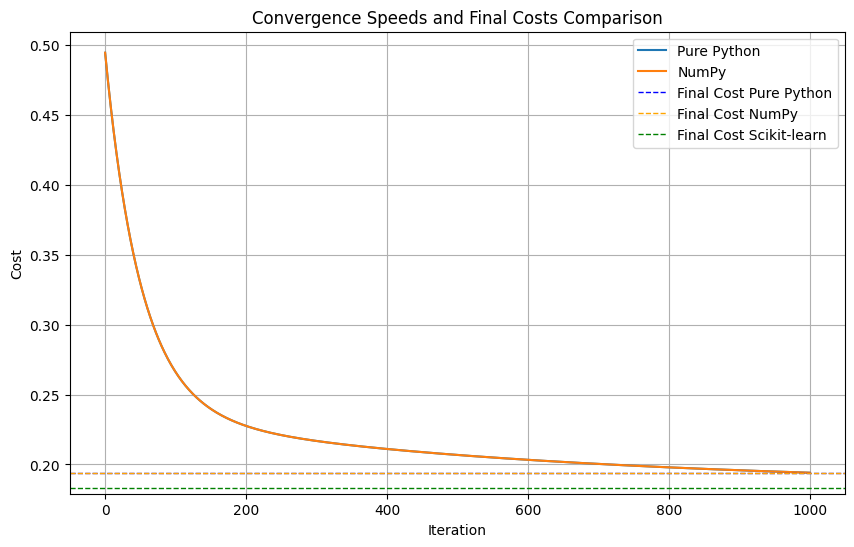

In [14]:
plt.figure(figsize=(10, 6))

# Plotting cost history for Pure Python and NumPy
plt.plot(cost_history_py, label='Pure Python')
plt.plot(cost_history_np, label='NumPy')

# Plotting horizontal lines for final costs of each method
plt.axhline(y=cost_history_py[-1], color='blue', linestyle='--', linewidth=1, label='Final Cost Pure Python')
plt.axhline(y=cost_history_np[-1], color='orange', linestyle='--', linewidth=1, label='Final Cost NumPy')
plt.axhline(y=cost_train_sk, color='green', linestyle='--', linewidth=1, label='Final Cost Scikit-learn')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Convergence Speeds and Final Costs Comparison')
plt.legend()
plt.grid(True)
plt.show()